# ОИАД. Лабораторная работа №3

## Входные данные
*   Для построения моделей: `datasets/insurance_train.csv`
*   Для оценки обобщающей способности: `datasets/insurance_test.csv`

Инфо о датасете: [Kaggle Link](https://www.kaggle.com/datasets/mosapabdelghany/medical-insurance-cost-dataset)

## Цель работы
1.  Подготовить данные (обработать категориальные признаки).
2.  Построить модель многомерной линейной регрессии аналитически.
3.  Построить модель многомерной линейной регрессии численно (градиентный спуск).
4.  Сравнить качество моделей на тестовой выборке.

## Основные формулы

### 1. Линейная регрессия
Модель зависимости целевой переменной $y$ от признаков $x_1, \dots, x_m$:
$$ y = w_0 + w_1 x_1 + \dots + w_m x_m = \sum_{j=0}^m w_j x_j $$
где $x_0 = 1$ (фиктивный признак для свободного члена).

В матричном виде:
$$ Y = XW $$

### 2. Аналитическое решение (Нормальное уравнение)
Минимизация среднеквадратичной ошибки приводит к решению:
$$ W = (X^T X)^{-1} X^T Y $$

### 3. Градиентный спуск
Минимизируемая функция потерь (MSE):
$$ L(W) = \frac{1}{n} || XW - Y ||^2 = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 $$

Градиент функции потерь по весам:
$$ \nabla_W L = \frac{2}{n} X^T (XW - Y) $$

Правило обновления весов (шаг обучения $\alpha$):
$$ W^{(k+1)} = W^{(k)} - \alpha \nabla_W L(W^{(k)}) $$

### 4. Метрики качества
Среднеквадратичная ошибка (MSE):
$$ MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 $$

### 5. Предобработка данных
Стандартизация (Z-score normalization):
$$ x'_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j} $$
где $\mu_j$ - среднее, $\sigma_j$ - стандартное отклонение $j$-го признака.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")

# Функция для поиска датасета
def load_dataset(filename):
    possible_paths = [
        f'../../datasets/{filename}',
        f'datasets/{filename}',
        f'/Users/qre/Desktop/oiad-13-2025/datasets/{filename}'
    ]
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Dataset {filename} found at: {path}")
            return pd.read_csv(path)
    raise FileNotFoundError(f"File {filename} not found in {possible_paths}")

df_train = load_dataset('insurance_train.csv')
df_test = load_dataset('insurance_test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
df_train.head()

Dataset insurance_train.csv found at: ../../datasets/insurance_train.csv
Dataset insurance_test.csv found at: ../../datasets/insurance_test.csv
Train shape: (338, 7)
Test shape: (1000, 7)


,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


## 1. Подготовка данных

1.  Привести категориальные признаки к числовым (`sex`, `smoker`, `region`).
2.  Вычислить парные корреляции.

In [10]:
# Проверка типов данных
print(df_train.info())

# Кодирование категориальных признаков
# sex: male/female -> 0/1
# smoker: yes/no -> 1/0
# region: закодируем числами 0, 1, 2, 3

def preprocess_data(df):
    df_encoded = df.copy()
    
    # Бинарные
    df_encoded['sex'] = df_encoded['sex'].map({'male': 0, 'female': 1})
    df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})
    
    # Region - Label Encoding
    regions = df_encoded['region'].unique()
    region_map = {r: i for i, r in enumerate(regions)}
    df_encoded['region'] = df_encoded['region'].map(region_map)
    
    return df_encoded, region_map

df_train_enc, region_map = preprocess_data(df_train)
# Применим ту же карту регионов к тесту, чтобы коды совпадали
df_test_enc = df_test.copy()
df_test_enc['sex'] = df_test_enc['sex'].map({'male': 0, 'female': 1})
df_test_enc['smoker'] = df_test_enc['smoker'].map({'yes': 1, 'no': 0})
df_test_enc['region'] = df_test_enc['region'].map(region_map)

print("Region map:", region_map)
df_train_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       338 non-null    int64  
 1   sex       338 non-null    object 
 2   bmi       338 non-null    float64
 3   children  338 non-null    int64  
 4   smoker    338 non-null    object 
 5   region    338 non-null    object 
 6   charges   338 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 18.6+ KB
None
Region map: {'southeast': 0, 'northwest': 1, 'southwest': 2, 'northeast': 3}


,age,sex,bmi,children,smoker,region,charges
0,26,0,27.060,0,1,0,17043.34140
1,58,0,36.955,2,1,1,47496.49445
2,20,1,24.420,0,1,0,26125.67477
3,51,1,38.060,0,1,0,44400.40640
4,62,1,25.000,0,0,2,13451.12200


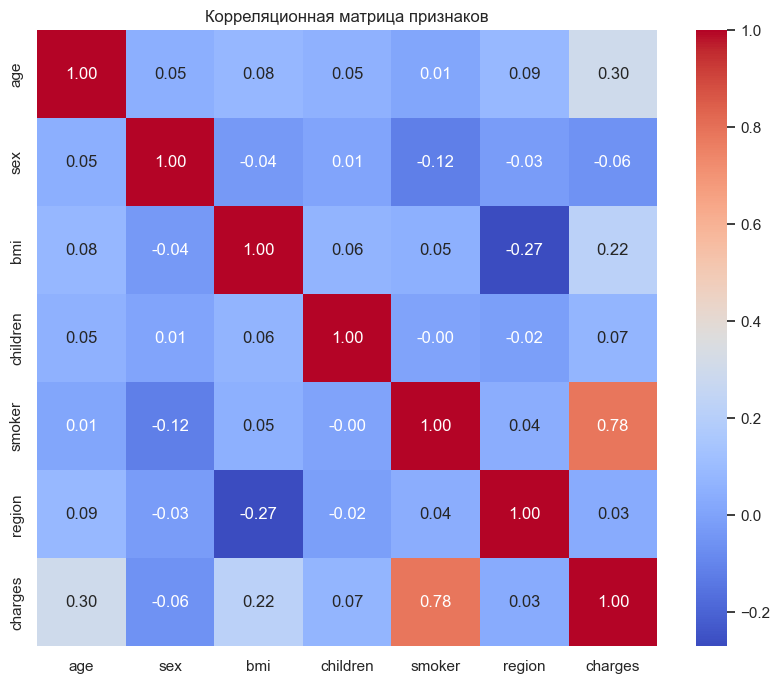

Корреляция с целевой переменной (charges):
charges     1.000000
smoker      0.783519
age         0.298395
bmi         0.219566
children    0.069444
region      0.031787
sex        -0.060221
Name: charges, dtype: float64


In [11]:
# Корреляционная матрица
plt.figure(figsize=(10, 8))
corr_matrix = df_train_enc.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.show()

print("Корреляция с целевой переменной (charges):")
print(corr_matrix['charges'].sort_values(ascending=False))

## 2. Многомерная линейная регрессия

Модель: $y = w_0 + w_1 x_1 + \dots + w_m x_m$

Матричная запись: $Y = XW$, где $X$ - матрица признаков (с добавленным столбцом единиц), $W$ - вектор весов.

### 2.1 Аналитическое решение
$$ W = (X^T X)^{-1} X^T Y $$

In [12]:
class LinearRegressionAnalytical:
    def __init__(self):
        self.weights = None
        
    def fit(self, X, y):
        # Добавляем столбец единиц (bias)
        X_b = np.c_[np.ones((len(X), 1)), X]
        
        # Формула нормального уравнения: w = (X^T * X)^(-1) * X^T * y
        X_T = X_b.T
        # np.linalg.inv вычисляет обратную матрицу
        try:
            self.weights = np.linalg.inv(X_T.dot(X_b)).dot(X_T).dot(y)
        except np.linalg.LinAlgError:
            print("Матрица вырождена, используем псевдообратную")
            self.weights = np.linalg.pinv(X_b).dot(y)
            
    def predict(self, X):
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b.dot(self.weights)

# Подготовка данных (X и y)
X_train = df_train_enc.drop('charges', axis=1).values
y_train = df_train_enc['charges'].values

X_test = df_test_enc.drop('charges', axis=1).values
y_test = df_test_enc['charges'].values

# Обучение
model_analytic = LinearRegressionAnalytical()
model_analytic.fit(X_train, y_train)

print("Веса модели (Аналитическое):", model_analytic.weights)
print("Feature weights match columns:", ['Bias'] + list(df_train_enc.drop('charges', axis=1).columns))

Веса модели (Аналитическое): [-12712.84747596    254.86031742    640.0459544     333.91199727
    474.12681688  23483.03768369    286.02201148]
Feature weights match columns: ['Bias', 'age', 'sex', 'bmi', 'children', 'smoker', 'region']


### 2.2 Численное решение (Градиентный спуск)

Функция потерь (MSE):
$$ L(W) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n} || XW - Y ||^2 $$

Градиент:
$$ \nabla_W L = \frac{2}{n} X^T (XW - Y) $$

Шаг обновления:
$$ W = W - \alpha \nabla_W L $$

**Важно:** Для градиентного спуска желательно масштабировать признаки (StandardScaler).

Epoch 0, MSE: 361762629.90
Epoch 200, MSE: 44722027.01
Epoch 400, MSE: 44618892.11
Epoch 600, MSE: 44618839.77
Epoch 800, MSE: 44618839.71
Epoch 1000, MSE: 44618839.71
Epoch 1200, MSE: 44618839.71
Epoch 1400, MSE: 44618839.71
Epoch 1600, MSE: 44618839.71
Epoch 1800, MSE: 44618839.71


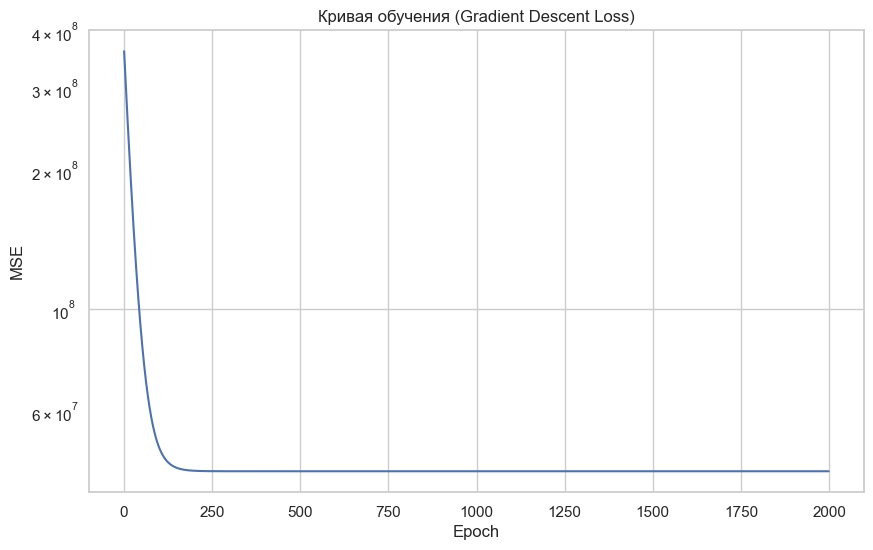

Веса модели (GD): [14092.8619242   3470.57172764   319.74833945  2103.7684865
   570.86604212  9893.99189084   328.14097785]


In [13]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.loss_history = []
        
    def fit(self, X, y):
        # Добавляем bias
        X_b = np.c_[np.ones((len(X), 1)), X]
        n_samples, n_features = X_b.shape
        
        # Инициализация весов (случайно или нулями)
        self.weights = np.random.randn(n_features)
        
        for i in range(self.epochs):
            # Предсказание
            y_pred = X_b.dot(self.weights)
            
            # Ошибка
            error = y_pred - y
            
            # Градиент: 2/n * X^T * error
            gradient = (2 / n_samples) * X_b.T.dot(error)
            
            # Обновление весов
            self.weights -= self.lr * gradient
            
            # Сохраним Loss для графика
            mse = np.mean(error ** 2)
            self.loss_history.append(mse)
            
            if i % (self.epochs // 10) == 0:
                print(f"Epoch {i}, MSE: {mse:.2f}")
                
    def predict(self, X):
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b.dot(self.weights)

# Стандартизация данных для GD (Z-score normalization)
# x_new = (x - mean) / std
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train_scaled = (X_train - X_mean) / X_std
X_test_scaled = (X_test - X_mean) / X_std # Используем параметры train для test!

# Обучение
model_gd = LinearRegressionGD(learning_rate=0.01, epochs=2000)
model_gd.fit(X_train_scaled, y_train)

# График обучения
plt.figure(figsize=(10, 6))
plt.plot(model_gd.loss_history)
plt.title('Кривая обучения (Gradient Descent Loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.show()

print("Веса модели (GD):", model_gd.weights)

## 3. Оценка обобщающей способности

Сравниваем модели по MSE (Mean Squared Error) на тестовой выборке:
$$ MSE = \frac{1}{n} \sum (y_{true} - y_{pred})^2 $$

Сравниваем:
1.  Константную модель (прогноз средним по train).
2.  Аналитическую модель.
3.  Модель градиентного спуска.

MSE Константной модели: 141,830,094.36
MSE Аналитической модели: 34,150,393.43
MSE Градиентного спуска: 34,150,393.43


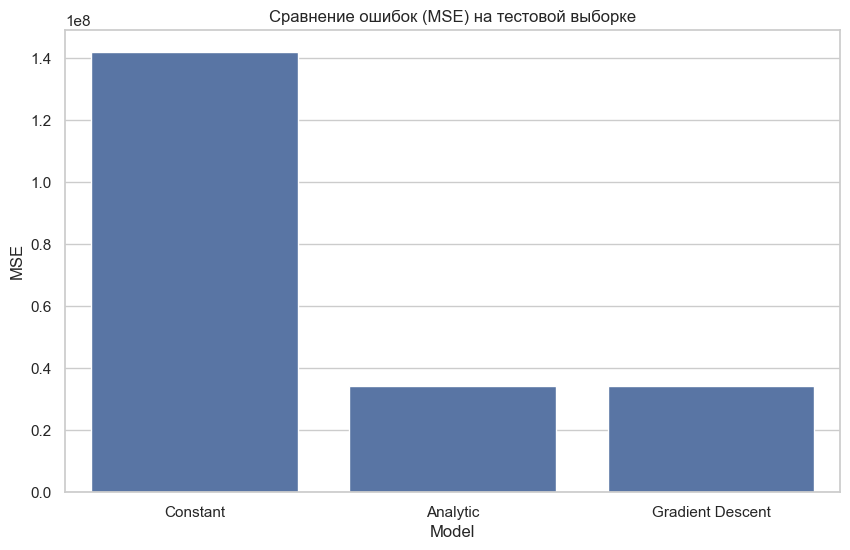

In [14]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# 1. Константная модель
y_pred_const = np.full_like(y_test, y_train.mean())
mse_const = mse(y_test, y_pred_const)

# 2. Аналитическая модель
y_pred_analytic = model_analytic.predict(X_test)
mse_analytic = mse(y_test, y_pred_analytic)

# 3. Градиентный спуск
y_pred_gd = model_gd.predict(X_test_scaled)
mse_gd = mse(y_test, y_pred_gd)

print(f"MSE Константной модели: {mse_const:,.2f}")
print(f"MSE Аналитической модели: {mse_analytic:,.2f}")
print(f"MSE Градиентного спуска: {mse_gd:,.2f}")

# Сравнение
results = pd.DataFrame({
    'Model': ['Constant', 'Analytic', 'Gradient Descent'],
    'MSE': [mse_const, mse_analytic, mse_gd]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Model', y='MSE')
plt.title("Сравнение ошибок (MSE) на тестовой выборке")
plt.show()

### Выводы
1.  **Подготовка данных:** Категориальные признаки были переведены в числовой вид. Обнаружена сильная корреляция между `charges` и `smoker`.
2.  **Линейная регрессия:** Реализованы два метода нахождения коэффициентов.
    *   Аналитический метод дает точное решение за один шаг (требует обратной матрицы).
    *   Градиентный спуск требует настройки learning rate и количества эпох, а также масштабирования признаков.
3.  **Результаты:**
    *   Константная модель показывает наихудший результат (самый высокий MSE).
    *   Аналитическая модель и метод градиентного спуска показали схожие результаты (значительно лучше константной), что говорит о том, что алгоритм градиентного спуска сошелся к оптимуму.
    *   Признак курильщика (`smoker`) оказывает наибольшее влияние на стоимость страховки.